# Morphology Feature Extraction
First we load all the data and names:


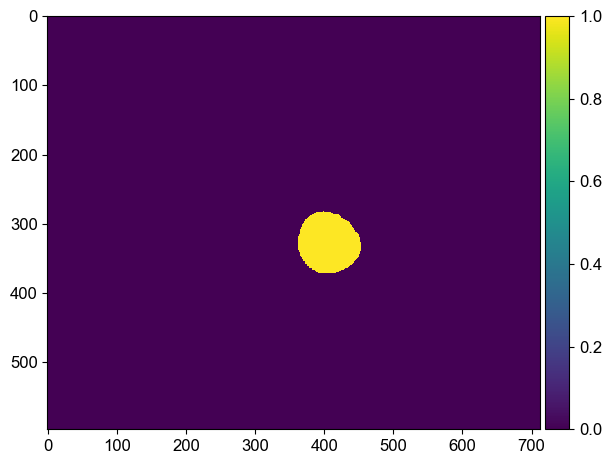

In [1]:
from skimage import io
import os
import numpy as np
import organoid_prediction_python as opp
import pandas as pd

# needs to be changed to repository directory
home_directory = r"C:\Users\savill\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
folder_masks = home_directory + r"image_data\Processed Data\Masks Brightfield\48h"
folder_bf = home_directory + r"image_data\Processed Data\Focussed Images\48h\Brightfield"
folder_bra = home_directory + r"image_data\Processed Data\Focussed Images\48h\Brachyury"

bf_collection = io.imread_collection(folder_bf+"/*.tif")
file_names_bf = [os.path.split(fname)[1] for fname in bf_collection.files]

mask_collection = io.imread_collection(folder_masks+"/*.tif")
file_names_mask = [os.path.split(fname)[1] for fname in mask_collection.files]

bra_collection = io.imread_collection(folder_bra+"/*.tif")
file_names_bra = [os.path.split(fname)[1] for fname in bra_collection.files]

io.imshow(mask_collection[371])

## Simple Morphology

In [2]:
dfs = []
for mask, img in zip(mask_collection,bf_collection):
        dfs.append(pd.DataFrame(opp.simple_brightfield_regionprops(mask,img)))
    
df =  pd.concat(dfs,axis =0,ignore_index=True)

pixel_size = 2.7493
length_columns = ["axis","perimeter","diameter"]
for column in df.columns:
    if any([length in column for length in length_columns]):
        df[column] = df[column].to_numpy() * pixel_size
    if ("area" in column) and ("fraction" not in column): 
        df[column] = df[column].to_numpy() * (pixel_size**2)

sample_identifier = opp.extract_sample_identifiers(file_names_bf)
output_dataframe = pd.concat([sample_identifier.drop("Filename",axis=1),df],axis=1)
output_dataframe.set_index(["Run","Plate","ID"],inplace=True)
output_dataframe

area   perimeter  axis_major_length  axis_minor_length  \
Run Plate ID                                                                    
RR  1     A1   51429.057934  848.528995         260.694837         251.609209   
          A2   46107.767989  807.094108         244.753205         240.312256   
          A3   54482.752732  885.017919         272.945953         255.001802   
          A4   46999.688747  817.033443         251.337713         238.375438   
          A5   50680.751535  844.917216         262.580886         246.040977   
...                     ...         ...                ...                ...   
TR  2     H8   47634.615388  822.255724         255.443622         237.781139   
          H9   45616.455707  798.260048         257.800200         225.832628   
          H10  42336.001394  769.823637         234.372899         230.412135   
          H11  40484.132024  758.159345         231.114030         223.328768   
          H12  44648.948444  792.485129         241.897406         235.285546   

               eccentricity  feret_diameter_max  solidity  aspect_ratio  
Run Plate ID                                                             
RR  1     A1       0.261703          266.724612  0.985088      0.965148  
          A2       0.189631          252.890770  0.984030      0.981855  
          A3       0.356599          280.334245  0.983893      0.934257  
          A4       0.316996          256.319703  0.985420      0.948427  
          A5       0.349302          267.361474  0.985450      0.937010  
...                     ...                 ...       ...           ...  
TR  2     H8       0.365387          260.429973  0.984534      0.930856  
          H9       0.482314          262.626514  0.984502      0.875999  
          H10      0.183066          242.141388  0.985571      0.983101  
          H11      0.257365          237.301383  0.983294      0.966314  
          H12      0.232206          248.123373  0.982698      0.972667  

[768 rows x 8 columns]

Saving the table

In [3]:
output_location = home_directory + r"tabular_data\48h"

if not os.path.exists(output_location):
   os.makedirs(output_location)
   print("The new directory is created!")

output_dataframe.to_csv(f"{output_location}/simple_shape_features_48h.csv")

## Straight Morphology
Complex morphology is calculated using the straightened masks as implemented in MOrgAna. First we'll test the straightening and then do the analysis:

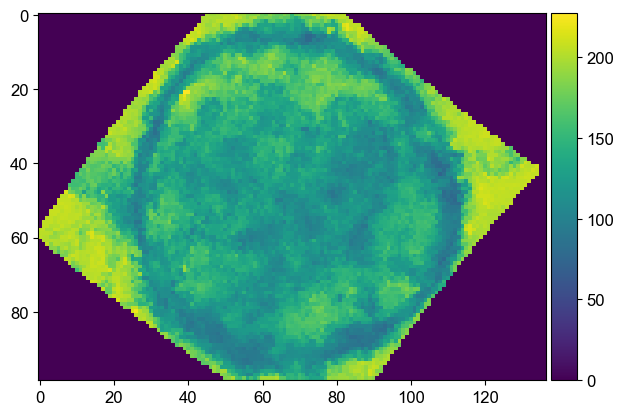

In [4]:
idx = 371
ma_test, bf_test = opp.straighten_mask_and_image(mask_collection[idx],bf_collection[idx])
io.imshow(bf_test)

In [5]:
%%time

straight_masks = []
straight_bra = []

for mask, img in zip(mask_collection,bra_collection):
    ma_straight, bra_straight = opp.straighten_mask_and_image(mask,img)
    straight_masks.append(ma_straight)
    straight_bra.append(bra_straight)
    
straight_morgana_features = opp.calculate_morgana_shapes(straight_masks,mask_collection.files)
straight_morgana_features

CPU times: total: 17min 38s
Wall time: 18min 54s


,area,eccentricity,major_axis_length,minor_axis_length,equivalent_diameter,perimeter,extent,orientation,form_factor,input_file,...,locoefa_coeff_42,locoefa_coeff_43,locoefa_coeff_44,locoefa_coeff_45,locoefa_coeff_46,locoefa_coeff_47,locoefa_coeff_48,locoefa_coeff_49,locoefa_coeff_50,locoefa_coeff_51
0,6816,0.314639,96.032169,91.154819,93.157934,329.261977,0.764297,-0.150401,1.265738,result_segmentation\FK223_run_RR_PLATE_1_ID_A1...,...,0.038298,0.019001,0.054324,0.101992,0.043425,0.06567,0.035491,0.027556,0.035581,0.0
1,6090,0.186483,88.930338,87.370347,88.056964,300.563492,0.76049,-0.063457,1.180444,result_segmentation\FK223_run_RR_PLATE_1_ID_A2...,...,0.095265,0.048376,0.060065,0.035707,0.00918,0.012755,0.036664,0.025098,0.014254,0.0
2,7283,0.401598,101.065671,92.55756,96.296436,343.605122,0.752998,-0.037351,1.290028,result_segmentation\FK223_run_RR_PLATE_1_ID_A3...,...,0.078012,0.076397,0.044291,0.038318,0.065456,0.078844,0.026782,0.020088,0.028813,0.0
3,6203,0.324276,91.43236,86.491591,88.870158,303.906638,0.792007,-0.497577,1.184865,result_segmentation\FK223_run_RR_PLATE_1_ID_A4...,...,0.094732,0.036762,0.076327,0.047514,0.069641,0.021901,0.064763,0.028653,0.020842,0.0
4,6807,0.363286,96.634305,90.032009,93.09641,329.190909,0.771157,0.331863,1.266864,result_segmentation\FK223_run_RR_PLATE_1_ID_A5...,...,0.035435,0.042075,0.01664,0.069348,0.044881,0.059128,0.025603,0.023746,0.024992,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,6202,0.294682,90.971187,86.931641,88.862994,311.806133,0.75745,-0.112641,1.247463,result_segmentation\FK223_run_TR_PLATE_2_ID_H8...,...,0.025803,0.037949,0.018497,0.070784,0.061659,0.069826,0.022833,0.016985,0.031887,0.0
764,5928,0.453513,92.135497,82.115752,86.877868,302.261977,0.758833,0.06713,1.226448,result_segmentation\FK223_run_TR_PLATE_2_ID_H9...,...,0.097314,0.070649,0.015102,0.053323,0.016186,0.022331,0.017621,0.058181,0.014007,0.0
765,5606,0.113534,84.995749,84.44618,84.485389,296.249783,0.776024,-0.46859,1.245814,result_segmentation\FK223_run_TR_PLATE_2_ID_H1...,...,0.052344,0.066822,0.073999,0.046818,0.004632,0.008939,0.043507,0.002143,0.0151,0.0
766,5266,0.212123,82.894513,81.00808,81.883328,289.918831,0.764518,-0.542037,1.270171,result_segmentation\FK223_run_TR_PLATE_2_ID_H1...,...,0.056405,0.065842,0.029929,0.092369,0.03904,0.009655,0.059363,0.016844,0.025526,0.0


In [6]:
df = straight_morgana_features

pixel_size = 2.7493
length_columns = ["axis","perimeter","diameter"]
for column in df.columns:
    if any([length in column for length in length_columns]):
        df[column] = df[column].to_numpy() * pixel_size
    if ("area" in column) and ("fraction" not in column): 
        df[column] = df[column].to_numpy() * (pixel_size**2)
        
sample_identifier = opp.extract_sample_identifiers(file_names_bf)
output_dataframe = pd.concat([sample_identifier.drop("Filename",axis=1),df.drop("input_file",axis=1)],axis=1)
output_dataframe.set_index(["Run","Plate","ID"],inplace=True)
output_dataframe

area eccentricity major_axis_length minor_axis_length  \
Run Plate ID                                                                   
RR  1     A1    51519.76174     0.314639        264.021242        250.611943   
          A2   46032.181484     0.186483        244.496177        240.207294   
          A3   55049.651519     0.401598         277.85985          254.4685   
          A4   46886.308989     0.324276        251.374987        237.791331   
          A5   51451.733885     0.363286        265.676695        247.525003   
...                     ...          ...               ...               ...   
TR  2     H8   46878.750339     0.294682        250.107084         239.00116   
          H9   44807.680105     0.453513        253.308121        225.760837   
          H10  42373.794647     0.113534        233.678813        232.167882   
          H11   39803.85348     0.212123        227.901885        222.715514   
          H12  44051.815056     0.243436        240.641964        233.402746   

              equivalent_diameter   perimeter    extent orientation  \
Run Plate ID                                                          
RR  1     A1           256.119109  905.239952  0.764297   -0.150401   
          A2            242.09501  826.339208   0.76049   -0.063457   
          A3           264.747792  944.673563  0.752998   -0.037351   
          A4           244.330724  835.530519  0.792007   -0.497577   
          A5            255.94996  905.044566  0.771157    0.331863   
...                           ...         ...       ...         ...   
TR  2     H8           244.311029    857.2486   0.75745   -0.112641   
          H9           238.853324  831.008852  0.758833     0.06713   
          H10          232.275679  814.479529  0.776024    -0.46859   
          H11          225.121834  797.073842  0.764518   -0.542037   
          H12          236.830135  840.200163  0.769983   -0.985041   

              form_factor aspect_ratio  ... locoefa_coeff_42 locoefa_coeff_43  \
Run Plate ID                            ...                                     
RR  1     A1     1.265738     1.053506  ...         0.038298         0.019001   
          A2     1.180444     1.017855  ...         0.095265         0.048376   
          A3     1.290028     1.091922  ...         0.078012         0.076397   
          A4     1.184865     1.057124  ...         0.094732         0.036762   
          A5     1.266864     1.073333  ...         0.035435         0.042075   
...                   ...          ...  ...              ...              ...   
TR  2     H8     1.247463     1.046468  ...         0.025803         0.037949   
          H9     1.226448      1.12202  ...         0.097314         0.070649   
          H10    1.245814     1.006508  ...         0.052344         0.066822   
          H11    1.270171     1.023287  ...         0.056405         0.065842   
          H12     1.27524     1.031016  ...         0.016412         0.071196   

              locoefa_coeff_44 locoefa_coeff_45 locoefa_coeff_46  \
Run Plate ID                                                       
RR  1     A1          0.054324         0.101992         0.043425   
          A2          0.060065         0.035707          0.00918   
          A3          0.044291         0.038318         0.065456   
          A4          0.076327         0.047514         0.069641   
          A5           0.01664         0.069348         0.044881   
...                        ...              ...              ...   
TR  2     H8          0.018497         0.070784         0.061659   
          H9          0.015102         0.053323         0.016186   
          H10         0.073999         0.046818         0.004632   
          H11         0.029929         0.092369          0.03904   
          H12         0.019547         0.053093         0.019201   

              locoefa_coeff_47 locoefa_coeff_48 locoefa_coeff_49  \
Run Plate ID                                       

Now we calculate the extent of polarisation of the brachyury signal using the straightened mask and straightened brachyury signal:

In [7]:
polarisation_props = opp.measure_brachyury_polarisation(straight_bra,straight_masks,file_names_bra)
sample_identifier = opp.extract_sample_identifiers(polarisation_props["filenames"])
df_polarisation = pd.concat([sample_identifier.drop("Filename",axis=1),polarisation_props.drop("filenames",axis=1)],axis=1)
df_polarisation.set_index(["Run","Plate","ID"],inplace=True)

df_polarisation

first_axis_polarisation  second_axis_polarisation
Run Plate ID                                                    
RR  1     A1                  0.033602                  0.009469
          A2                  0.006087                  0.002021
          A3                  0.043632                  0.003480
          A4                  0.003000                  0.005707
          A5                  0.026882                  0.017541
...                                ...                       ...
TR  2     H8                  0.005869                  0.005420
          H9                  0.011629                  0.020696
          H10                 0.007411                  0.010388
          H11                 0.002839                  0.002295
          H12                 0.003848                  0.016681

[768 rows x 2 columns]

Now we save the combined dataframe:

In [8]:
output_location = home_directory + r"tabular_data\48h"

if not os.path.exists(output_location):
   os.makedirs(output_location)
   print("The new directory is created!")

output_dataframe.to_csv(f"{output_location}/straight_morgana_shape_features_48h.csv")
df_polarisation.to_csv(f"{output_location}/straight_morgana_brachyury_polarisation_48h.csv")